# <font color=purple>**Proyecto Final Camp Women in Bioinformatics and Data Science 2023**

###**Alumna:** Elizabeth Cattáneo

## **OBJETIVO GENERAL:**

### - Identificar secuencias codificantes de proteínas asociadas a producción de [alfa-hemolisina](https://en.wikipedia.org/wiki/Hemolysin) en *Staphylococcus aureus*. 



### **Objetivos personales/didácticos:**
### - Adaptar el código para ser utilizado en Colab.
### - Marcar el lenguaje utilizado en cada bloque.
### - Aprender a realizar consultas mediante APIs. Similitudes y diferencias.

## **Introducción teórica**

### La alfa-hemolisina (HlyA) es una toxina proteica formadora de poros producida por distintas bacterias, como *S. aureus y Escherichia coli*, y tiene como célula blanco principal a los glóbulos rojos, pero también puede lisar otro tipo de células .

### La HlyA es un factor de virulencia importante en las cepas uropatogénicas de *E.coli*, que son capaces de producir infecciones urinarias altas y bajas.

### En *E. coli* la información necesaria para la síntesis, maduración postraduccional y secreción de HlyA está contenida en el **operón hlyCABD** el cual contiene la información para la expresión de:
### - el gen estructural de la síntesis de una pro-HlyA inactiva
### - el gen que codifica para la HlyC, una aciltransferasa que le adiciona ácidos grasos en 2 residuos de Lisina específicos a la pro-toxina para volverla activa.
### - el gen que codifica para una proteína portadora de acilos (ACP)
### - los genes que codifican para las proteínas HlyB y HlyD que son necesarias para la secreción de la toxina al medio extracelular.


## **Bibliografia:**

### El proyecto está basado en el siguiente [video](https://www.youtube.com/watch?v=iufNjwDA5_o&t=3822s&ab_channel=WomeninBioinformatics%26DataScienceLA)

## **El proyecto incluye los siguientes pasos:**

### - Búsqueda de genomas procariotas en bases de datos (NCBI - Genome)
### - Descarga semi automatizada de dichos genomas
### - Construcción de bases de datos de proteínas (Uniprot y blastp)
### - Determinación de secuencias codificantes (pyrodigal)
### - Análisis funcional de secuencias de proteínas (InterProScan)
### - Visualización de datos (pyCirclize y seaborn)

# 0. Preparación del entorno

### Los archivos y bibliotecas necesarios para que el código del notebook funcione son: 

### - [pandas](https://pandas.pydata.org/) para el manejo general de datos
### - [pyCirclize](https://moshi4.github.io/pyCirclize/) para visualizar nuestros datos genómicos
### - [pyrodigal](https://pyrodigal.readthedocs.io/en/stable/) para la predicción de genes codificantes
### - [requests](https://requests.readthedocs.io/en/latest/) para interactuar con las APIs de NCBI, UniProt e InterProScan
### - [seaborn](https://seaborn.pydata.org/) para visualizar algunas de las propiedades genómicas obtenidas
### - [subprocess](https://docs.python.org/3/library/subprocess.html) ejecutar comandos fuera del entorno de python
### - [BioPython](https://biopython.org/) para el manejo de secuencias
### - [io](https://docs.python.org/3/library/io.html) para conectar las entradas y salidas de los distintos programas

### **Lenguajes utilizados:**

### - Este notebook contiene código Python y código Bash. Las celdas en las que se ejecuta código Bash inician con el signo !

### - En este notebook también se van a realizar consultas a bases externas.

### Para instalar las bibliotecas mencionadas, hay que ejecutar los siguientes comandos

```bash
pip3 install matplotlib
pip3 install pandas
pip3 install pycirclize
pip3 install pyrodigal
pip3 install requests
pip3 install seaborn
pip3 install biopython
```

### - Las bibliotecas `sys`,`subprocess` y `io` forman parte del core de python por lo que no es necesario instalarlas.

### - En caso de ejecutar el notebook en Google Colab para instalar las bibliotecas debes agregar al inicio el símbolo **!** (por ejemplo: ! pip3 install pycirclize)

### - El entorno de Google Colab es temporal, entonces los bloques de código siguientes que sirven para instalar e importar las bibliotecas hay que ejecutarlos siempre que usemos en Notebook.

In [ ]:
# instalar bibliotecas
!pip3 install pyrodigal
!pip install --upgrade Biopython
!pip3 install pycirclize

In [ ]:
# cargar las bibliotecas
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pyrodigal
import requests
import seaborn as sns
import subprocess
import sys
from Bio import SeqIO
from Bio import Entrez
from io                 import StringIO
from matplotlib.patches import Patch
from pycirclize         import Circos
from pycirclize.parser  import Gff
from requests.adapters  import HTTPAdapter, Retry

### - Todos los archivos que se van generando quedan guardados (temporalmente) en la carpeta de Colab que está a la izquierda del código y desde ahí pueden descargarse.

### 1. Obtención de una secuencia genómica

### La secuencia de *S. aureus* la obtuve del sitio web de [NCBI - Genome](https://www.ncbi.nlm.nih.gov/data-hub/genome) y corresponde al ensamble [ASM2662542v1](https://www.ncbi.nlm.nih.gov/data-hub/genome/GCA_026625425.1/).  

### Los genes necesarios para la producción de alfa-hemolisina los voy a buscar en el cromosoma con número de acceso [CP113040.1](https://www.ncbi.nlm.nih.gov/nuccore/CP113040.1/)

### Con las siguientes líneas de código podemos descargar el genoma de nuestro interés en formato genbank.

### El genoma se almacena como un objeto de tipo `sequence` por lo que fisicamente no existe el archivo en nuestro disco duro a menos que lo guardemos.

In [ ]:
# Para descargar los datos de NCBI
accession = "CP113040.1"                # núm. acceso del cromosoma
genome = Entrez.efetch(db="nucleotide",  # base de datos consultada
                       id=accession,
                       format="gb",      # formato salida gene bank
                       rettype="text")   
# para guardarlos
record = SeqIO.read(genome, "genbank")
genome_length = len(record.seq)

In [ ]:
genome_length

2925774

In [ ]:
# info del genoma que estamos descargando
record

SeqRecord(seq=Seq('CTTGCAAGAGGTGGCGCAACAATGGCAACAGTTCCAATAGGTAAAGAAGCGGTA...ATC'), id='CP113040.1', name='CP113040', description='Staphylococcus aureus strain Lissandra chromosome, complete genome', dbxrefs=['BioProject:PRJNA895753', 'BioSample:SAMN31523640'])

### 2. Predicción de genes usando pyrodigal

### Pyrodigal es una implementación en Python de un programa que permite encontrar ORFs y proporciona un soporte estadístico para evaluar la calidad de las predicciones.

### Para encontrar los genes que codifican para proteínas debemos usar las siguientes funciones de pyrodigal:

- ### OrfFinder: para encontrar posibles ORFs en el genoma (por tamaño)
- ### train: para entrenar un modelo estadístico
- ### find_genes: usar el modelo para predecir genes en ese genoma


In [ ]:
# inicializar pyrodigal
orf_finder = pyrodigal.OrfFinder()  
orf_finder.train(bytes(record.seq))
orf_genes  = orf_finder.find_genes(bytes(record.seq))

In [ ]:
# resultado de la predicción
orf_genes

### Los resultados de la predicción de pyrodigal están almacenados en el objeto `orf_genes`, y a partir de este objeto podemos obtener:
- ### las secuencias codificantes almacenadas en formato fasta
- ### las secuencias de aminoácidos derivadas de las secuencias codificantes almacenadas en formato fasta
- ### construir una tabla.gff (general feature format) que contenga las coordenadas de los genes predichos en este genoma

### Al momento de armar estos archivos es importante que especifiquemos un prefijo para indicar a que organismo pertenecen los datos que estamos almacenando (por si luego queremos agregarlos a una tabla con datos de otros organismos para comparar). En este caso estamos usando el genoma de *Staphylococcus aureus* de la cepa *Lissandra*, por lo que vamos a usar como prefijo **SaurLiss**

In [ ]:
# para obtener la secuencia de aa - archivo CP113040.1.faa
aa_file = accession + ".faa"  # armar el archivo
prefix  = "SaurLiss"          # definir el prefijo
with open(aa_file, "w") as orf_gene:
    orf_genes.write_translations(orf_gene,sequence_id=prefix)

In [ ]:
# para generar el archivo con las coordenadas - archivo CP113040.1.gff
gff_file = accession + ".gff"
prefix  = "SaurLiss"
with open(gff_file, "w") as orf_gene:
    orf_genes.write_gff(orf_gene,sequence_id=prefix)

### Para examinar el contenido de estos archivos usamos código Bash y el comando head que nos permite ver las primeras 10 líneas de cada archivo.

In [ ]:
!head CP113040.1.faa

>SaurLiss_1 # 1 # 540 # 1 # ID=1_1;partial=10;start_type=Edge;rbs_motif=None;rbs_spacer=None;gc_cont=0.398
LARGGATMATVPIGKEAVENSIYRQAEQIRGDLIILQGTDDDWLHGYWAGVPIGTDKTDT
KTFYGAFCSAIEVIRKNNPDSKILVMTATRQCPMSGTTIRRKDTDKNKLGLTLEDYVNAQ
ILACSELDVPVFDAYHTDYFKPYNPAFRKASMEDGLHPNEKGHEVIMYELIKDYYSFYD*
>SaurLiss_2 # 553 # 2451 # 1 # ID=1_2;partial=00;start_type=ATG;rbs_motif=AGGAGG;rbs_spacer=5-10bp;gc_cont=0.352
MAYGLITSLHSMTGRKIVAQHEYNYRLLDEGMSKLEKMFIYHQKEEIYAHSAKQIKYLND
SVEDYLTYLNGRFSNMILGHNGDGINEVKDARIDNTGYGHKTLQDRLYHDYSTLDAFTKK
VEKAVDEHYKEYRATEYRFEPKEQEPEFITDLSPYTNAVMQSFWVDPRTKIIYMTQARPG
NHYMLSRLKPNGQFIDRLLVKNGGHGTHNAYRYIDGELWIYSAVLDSNKNNKFVRFQYRT
GEITYGNEMQDVMPNIFNDRYTSAIYNPIENLMIFRREYKASERQAKNSLNFIEVRSADD


In [ ]:
!head CP113040.1.gff

##gff-version  3
# Sequence Data: seqnum=1;seqlen=2925774;seqhdr="SaurLiss"
# Model Data: version=pyrodigal.v2.1.0;run_type=Single;model="Ab initio";gc_cont=32.97;transl_table=11;uses_sd=1
SaurLiss	pyrodigal_v2.1.0	CDS	1	540	73.3	+	0	ID=SaurLiss_1;partial=10;start_type=Edge;rbs_motif=None;rbs_spacer=None;gc_cont=0.398;conf=100.00;score=73.30;cscore=70.08;sscore=3.22;rscore=0.00;uscore=0.00;tscore=3.22;
SaurLiss	pyrodigal_v2.1.0	CDS	553	2451	318.0	+	0	ID=SaurLiss_2;partial=00;start_type=ATG;rbs_motif=AGGAGG;rbs_spacer=5-10bp;gc_cont=0.352;conf=99.99;score=317.96;cscore=301.10;sscore=16.86;rscore=13.93;uscore=-1.02;tscore=2.81;
SaurLiss	pyrodigal_v2.1.0	CDS	2451	4274	305.8	+	0	ID=SaurLiss_3;partial=00;start_type=ATG;rbs_motif=AGxAGG/AGGxGG;rbs_spacer=5-10bp;gc_cont=0.363;conf=99.99;score=305.80;cscore=291.08;sscore=14.72;rscore=9.87;uscore=0.76;tscore=2.81;
SaurLiss	pyrodigal_v2.1.0	CDS	4274	4654	67.6	+	0	ID=SaurLiss_4;partial=00;start_type=ATG;rbs_motif=GGxGG;rbs_spacer=5-10bp;gc_cont=0

### - El archivo `CP113040.1.faa` lo vamos a usar para comparar con un set de secuencias de referencia obtenido de Uniprot
### - El archivo `CP113040.1.gff` lo vamos a usar para para visualizar las predicciones realizadas

### Los archivos que se van generando en el Notebook quedan guardados en la carpeta que se encuentra a la izquierda del código y desde ahí podemos descargarlos.

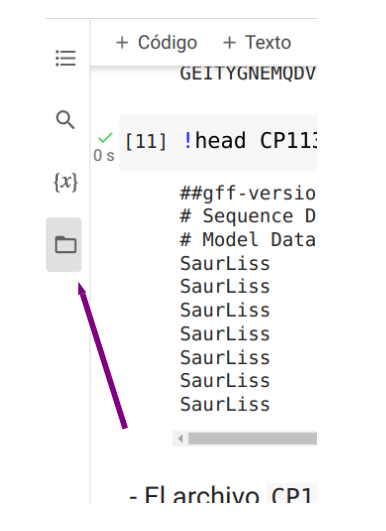

### 3. Obtención de un set de secuencias de referencia

### Una vez realizadas las predicciones de los genes presentes en nuestro ejemplo se deben buscar estos genes pero en otra base de datos que contenga la información acerca de su función.

### [UniProt](https://www.uniprot.org) es un repositorio en donde están albergadas secuencias de referencia de multiples organismos. Podemos emplear la interfaz web de UniProt, sin embargo para situaciones en donde tengamos que hacer búsquedas y descargas de forma repetitiva (o voluminosa) podemos usar la API de UniProt para conectarnos al servidor sin usar la página web.

### - Para interactuar con la API de UniProt usamos `requests`

### Con el siguiente código podemos descargar secuencias de UniProt en el objeto `uniprot_ref_seqs`

### Para armarlo debemos seleccionar con la **query** que genes queremos estudiar. Tener en cuenta que:
- ### cuanto más específica sea la búsqueda menos secuencias vamos a obtener.
- ### usar siempre el parámetro reviwed: True para obtener solo datos verificados.

### En este caso vamos a estudiar los genes relacionados con la síntesis de [alfa-hemolisina](https://www.uniprot.org/uniprotkb/Q2G1X0/entry) pertenecientes a un set de referencia verificado 

In [ ]:
# Para interactuar con la API de Uniprot
# Guardamos la dirección del servidor en una variable
uniprot_api_url  = "https://rest.uniprot.org/uniprotkb/stream"   # esta info está en el help de Uniprot
# Guardamos en un diccionario de Python los datos que queremos descargar de la API
uniprot_api_args = {"compressed" : "false",
                    "format"     : "fasta",
                    "query"      : "(Alpha-hemolysin) AND (reviewed:true)"}
                    
# Hacemos la consulta a la API
uniprot_ref_seqs = requests.get(uniprot_api_url,params=uniprot_api_args).text

### Esto nos permite obtener las proteínas en formato fasta

In [ ]:
# para ver las proteínas encontradas
uniprot_ref_seqs

">sp|A0A0H3PEK7|TLYA_CAMJJ 23S rRNA (cytidine-2'-O)-methyltransferase TlyA OS=Campylobacter jejuni subsp. jejuni serotype O:23/36 (strain 81-176) OX=354242 GN=tlyA PE=1 SV=1\nMRFDFFVSKRLNISRNKALELIENEEVLLNGKSFKASFDVKNFLENLKKTQDLNPEDILL\nTDGLKLDLLSEIYVSRAALKLKNFLEENGIEIKHKNCLDIGSSTGGFVQILLENQALKIT\nALDVGNNQLHLSLRTNEKIILHENTDLRTFKSEEKFELITCDVSFISLINLLYYIDNLAL\nKEIILLFKPQFEVGKNIKRDKKGVLKDDKAILKARMDFEKACAKLGWLLKNTQKSSIKGK\nEGNVEYFYYYIKN\n>sp|O14672|ADA10_HUMAN Disintegrin and metalloproteinase domain-containing protein 10 OS=Homo sapiens OX=9606 GN=ADAM10 PE=1 SV=1\nMVLLRVLILLLSWAAGMGGQYGNPLNKYIRHYEGLSYNVDSLHQKHQRAKRAVSHEDQFL\nRLDFHAHGRHFNLRMKRDTSLFSDEFKVETSNKVLDYDTSHIYTGHIYGEEGSFSHGSVI\nDGRFEGFIQTRGGTFYVEPAERYIKDRTLPFHSVIYHEDDINYPHKYGPQGGCADHSVFE\nRMRKYQMTGVEEVTQIPQEEHAANGPELLRKKRTTSAEKNTCQLYIQTDHLFFKYYGTRE\nAVIAQISSHVKAIDTIYQTTDFSGIRNISFMVKRIRINTTADEKDPTNPFRFPNIGVEKF\nLELNSEQNHDDYCLAYVFTDRDFDDGVLGLAWVGAPSGSSGGICEKSKLYSDGKKKSLNT\nGIITVQNYGSHVPPKVSHITFAHEVGHNFGSPHDSGTECTPGESKNLGQKENGNYIMYA

### Por último debemos pasar las secuencias en formato fasta a un archivo (`uniprot_sequences.fasta`) en nuestro disco duro

In [ ]:
# guardar secuencias de referencia en el disco
uniprot_seqs_file = open("uniprot_sequences.fasta", "wt")
uniprot_seqs_file.write(uniprot_ref_seqs)
uniprot_seqs_file.close()

In [ ]:
!head uniprot_sequences.fasta

>sp|A0A0H3PEK7|TLYA_CAMJJ 23S rRNA (cytidine-2'-O)-methyltransferase TlyA OS=Campylobacter jejuni subsp. jejuni serotype O:23/36 (strain 81-176) OX=354242 GN=tlyA PE=1 SV=1
MRFDFFVSKRLNISRNKALELIENEEVLLNGKSFKASFDVKNFLENLKKTQDLNPEDILL
TDGLKLDLLSEIYVSRAALKLKNFLEENGIEIKHKNCLDIGSSTGGFVQILLENQALKIT
ALDVGNNQLHLSLRTNEKIILHENTDLRTFKSEEKFELITCDVSFISLINLLYYIDNLAL
KEIILLFKPQFEVGKNIKRDKKGVLKDDKAILKARMDFEKACAKLGWLLKNTQKSSIKGK
EGNVEYFYYYIKN
>sp|O14672|ADA10_HUMAN Disintegrin and metalloproteinase domain-containing protein 10 OS=Homo sapiens OX=9606 GN=ADAM10 PE=1 SV=1
MVLLRVLILLLSWAAGMGGQYGNPLNKYIRHYEGLSYNVDSLHQKHQRAKRAVSHEDQFL
RLDFHAHGRHFNLRMKRDTSLFSDEFKVETSNKVLDYDTSHIYTGHIYGEEGSFSHGSVI
DGRFEGFIQTRGGTFYVEPAERYIKDRTLPFHSVIYHEDDINYPHKYGPQGGCADHSVFE


### 4. Creación de una base de datos tipo BLAST

### La idea es hacer alineamientos locales y encontrar regiones de similitud entre dos conjuntos de proteínas. la base de datos se puede armar con las secuencias obtenidas de pyrodigal o con las obtenidas de Uniprot; para optimizar el uso de recursos lo recomendable es hacerla con el set de datos más grande.

### Entonces a partir de las secuencias aminoacídicas de las predicciones de pyrodigal podemos crear una base de datos tipo BLAST que usaremos para tratar de encontrar secuencias similares a las secuencias obtenidas en UniProt.

### Para esto vamos a usar la función *call* de la biblioteca **subproccess**, esto permite ejecutar código fuera del entorno de Python. Además vamos a usar **makeblastdb** que es una aplicación de Blast que permite construir bases de datos.

### Para poder usar makeblastdb hay que seguir los siguientes pasos:
### 1) descargar de la siguiente [página](https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/) que contiene los ejecutables de Blast el correspondiente a tu sistema operativo (en mi caso Linux) 

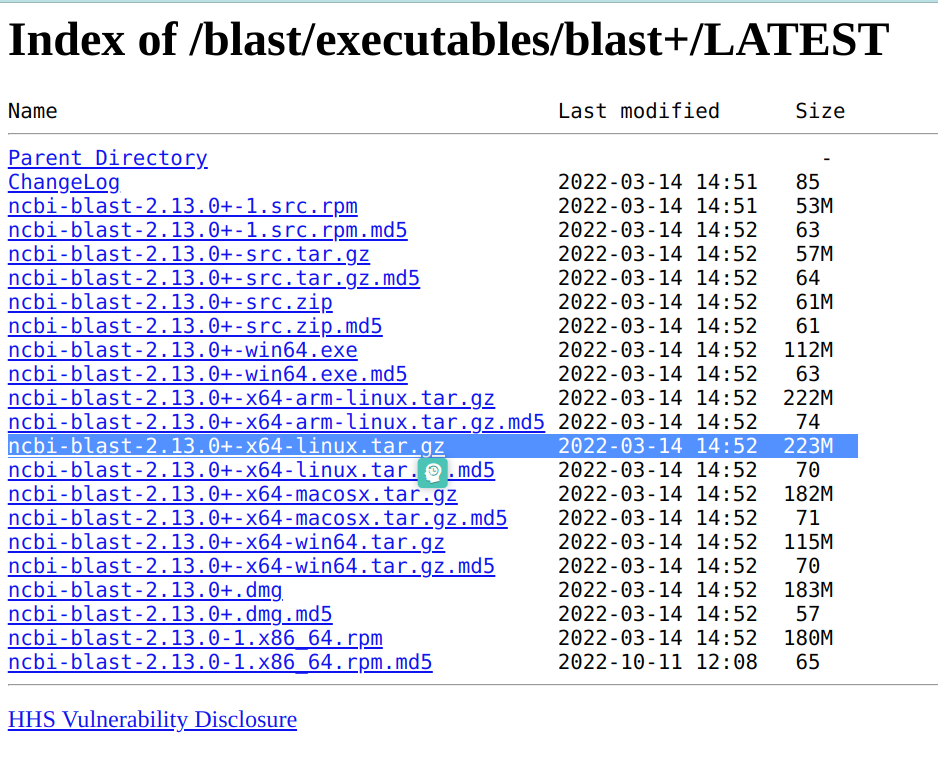

### 2) Descomprimirlo.
### 3) Buscar adentro de la carpeta **bin** el archivo **makebalstdb** y subirlo a Colab (a la carpeta content) utilizando el botón de carga de archivos que está a la izquierda del código. 
- ### Para usarlo tengo que darle el permiso de ejecución (sino tira error)



### Luego con el siguiente código le pasamos distintos argumentos al comando `makeblastdb` para construir la base de datos usando el archivo `aa_file` que definimos anteriormente (y que contiene las secuencias de aa predichas con pyrodigal)

In [ ]:
# otorgar permiso de ejecución
!chmod a+x /content/makeblastdb

In [ ]:
# para crear la db
# cargo la ruta al archivo que descargue de Blast (guardado en la carpeta content de Colab)
makeblastdb_path = "/content/makeblastdb"
# armo la db de tipo proteina usando las secuencias de aa_file (predicciones de pyrodigal)
makeblastdb_command = [makeblastdb_path,'-in',aa_file,'-dbtype','prot']
subprocess.call(makeblastdb_command)

0

### Con esto lo que hicimos fue indexar las proteínas del genoma para poder buscarlas en la base que descargamos de Uniprot.

### 5. Obtención de secuencias de interés en el genoma analizado

### Hasta ahora tenemos 2 archivos de proteínas:
- ### las correspondientes al genoma descargado
- ### las que descargamos de Uniprot haciendo la búsqueda específica con la query

### Para saber cuántas proteínas hay en cada archivo:

In [ ]:
# recuento de proteinas en el genoma descargado
!grep -o ">" CP113040.1.faa | wc -l

2796


In [ ]:
# recuento de proteinas descargadas de Uniprot
!grep -o ">" uniprot_sequences.fasta | wc -l 

66


### Ahora la idea es comparar ambos sets para ver que secuencias en nuestro genoma podrían potencialmente estar involucradas en biosíntesis de alfa-hemolisina.

### Para esto tengo que importar a Colab el archivo **blastp** (que es otra aplicación de Blast) y darle permiso de ejecución para poder usarlo. 



### Con el siguiente código podemos llamar a BLAST, y obtener una tabla con los resultados de la comparación

In [ ]:
# otorgar permisos a blastp
!chmod a+x /content/blastp

In [ ]:
# Para comparar las secuencias de uniprot contra las secuencias del genoma
blastp_path       = "/content/blastp"  # conectamos con blast
blastp_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive" # para poner nombres a las columnas
blastp_out_file   = accession + ".blast.tsv" # indicamos que la salida sea una tabla
blastp_command    = [blastp_path,
                     "-db",          aa_file,  # usamos de base las secuencias del genoma
                     "-query",       "uniprot_sequences.fasta", # y de query las sec de Uniprot
                     "-evalue",      "1e-9",
                     "-out",         blastp_out_file,
                     "-outfmt",      blastp_out_format,
                     "-num_threads", "12"]
subprocess.call(blastp_command)

0

### Con esto a partir de las secuencias de Uniprot podemos determinar si en nuestro genoma hay proteínas que tienen que ver con la síntesis de alfa-hemolisina.

### También podría comparar las secuencias obtenidas del genoma contra las secuencias de Uniprot cambiando los archivos que uso como db y como query, y usando el siguiente código

```python
# armo la db con las secuencias de Uniprot
makeblastdb_path = "/content/makeblastdb"
makeblastdb_command = [makeblastdb_path,'-in',"uniprot_sequences.fasta",'-dbtype','prot']
subprocess.call(makeblastdb_command)

# uso Blast para comparar y crear la tabla
# comparar las secuencias del genoma contra una base de datos construída con Uniprot
blastp_path      = "content/blastp"
blast_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blast_out_file   = "uniprot_sequences.blast.tsv"
blastp_command   = [blastp_path,
                    "-db",          "uniprot_sequences.fasta", # de db Uniprot
                    "-query",       aa_file,  # de consulta las del genoma
                    "-evalue",      "1e-9",
                    "-out",         blast_out_file,
                    "-outfmt",      out_format,
                    "-num_threads", "12"]
subprocess.call(blastp_command)
```

* Ambos resultados son complementarios, y examinarlos por separado podría ser de utilidad para detectar resultados espureos. Si hay una proteína que da en una búsqueda y no en la otra significa que ese resultado pudo haber sido más por azar que por una cuestión biológica.

In [ ]:
# para ver la tabla generada
!head CP113040.1.blast.tsv

sp|P08716|HLYBP_ECOLX	SaurLiss_2696	707	579	149	13	706	577	845	2.01e-105	568	322
sp|P08716|HLYBP_ECOLX	SaurLiss_1243	707	576	231	95	692	559	610	2.32e-71	470	260
sp|P08716|HLYBP_ECOLX	SaurLiss_2143	707	578	386	254	706	570	546	2.97e-62	322	195
sp|P08716|HLYBP_ECOLX	SaurLiss_2142	707	571	164	31	691	561	491	1.13e-54	553	272
sp|P08716|HLYBP_ECOLX	SaurLiss_1427	707	342	468	2	696	234	330	1.09e-34	238	134
sp|P08716|HLYBP_ECOLX	SaurLiss_2704	707	243	484	18	695	230	322	1.19e-34	225	130
sp|P08716|HLYBP_ECOLX	SaurLiss_1203	707	544	468	323	687	531	325	8.98e-33	222	123
sp|P08716|HLYBP_ECOLX	SaurLiss_2160	707	244	484	16	701	237	304	2.90e-32	230	133
sp|P08716|HLYBP_ECOLX	SaurLiss_1072	707	342	475	11	695	233	308	8.15e-32	239	135
sp|P08716|HLYBP_ECOLX	SaurLiss_2348	707	270	461	1	697	236	283	4.05e-29	243	129


### En esta tabla la primera columna corresponde a las proteínas de Uniprot y la segunda a las del genoma.

### A continuación le ponemos nombre a las columnas de esta tabla.

# **6. Examinación de los resultados de la búsqueda tipo BLAST**

### Los resultados de la búsqueda tipo BLAST están en el archivo `CP113040.1.blast.tsv`, sin embargo dicha tabla no contiene los nombres de las columnas

### Podemos importar esta tabla a un dataframe de pandas y asignar los nombres de las columnas usando la variable `blastp_out_format` que definimos anteriormente

In [ ]:
# convertir la tabla en un df
blastp_column_names = blastp_out_format.split(" ")[1:] # para tomar desde el 2do de la lista
blastp_df = pd.read_csv(blastp_out_file,sep="\t",names=blastp_column_names)

In [ ]:
blastp_df

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive
0,sp|P08716|HLYBP_ECOLX,SaurLiss_2696,707,579,149,13,706,577,845,2.010000e-105,568,322
1,sp|P08716|HLYBP_ECOLX,SaurLiss_1243,707,576,231,95,692,559,610,2.320000e-71,470,260
2,sp|P08716|HLYBP_ECOLX,SaurLiss_2143,707,578,386,254,706,570,546,2.970000e-62,322,195
3,sp|P08716|HLYBP_ECOLX,SaurLiss_2142,707,571,164,31,691,561,491,1.130000e-54,553,272
4,sp|P08716|HLYBP_ECOLX,SaurLiss_1427,707,342,468,2,696,234,330,1.090000e-34,238,134
...,...,...,...,...,...,...,...,...,...,...,...,...
399,sp|Q99RD6|SART_STAAM,SaurLiss_2068,118,248,20,20,114,112,126,1.350000e-10,95,57
400,sp|Q99RP3|SARZ_STAAM,SaurLiss_2186,148,149,1,1,148,148,740,1.250000e-103,148,148
401,sp|Q99RP3|SARZ_STAAM,SaurLiss_1201,148,148,8,7,148,147,212,1.790000e-23,142,88
402,sp|Q2FYM7|TELL_STAA8,SaurLiss_465,378,379,1,1,378,378,1945,0.000000e+00,378,377


### En esta tabla cada columna corresponde a:
- qseqid: proteínas de Uniprot
-	sseqid: proteínas del genoma
-	qlen: cantidad de aa de la proteína de Uniprot
-	slen: cantidad de aa de la proteína del genoma
-	qstart: aa en el que inicia el alineamiento en la proteína de Uniprot
-	sstart: aa en el que inicia el alineamiento en la proteína del genoma
-	qend: aa en el que termina el alineamiento en la proteína de Uniprot
-	send: aa en el que termina el alineamiento en la proteína del genoma
-	score: del alineamiento
-	evalue: valor de expectancia
-	length: longitud del alineamiento
-	positive: número de aa que son similares entre las 2 secuencias

In [ ]:
# para identificar las posibles proteínas de interes
# cuento elementos únicos en la columna del genoma
candidate_genes=blastp_df["sseqid"].unique().tolist()
len(candidate_genes)

87

### En el genoma de interés encontramos 87 proteínas *potencialmente* asociadas con síntesis de alfa-hemolisina.

## 6.1. Visualización preliminar de los datos

### A través de la biblioteca pyCirclize podemos visualizar los genes que fueron identificados en el paso anterior, pero primero debemos transformar la información que tenemos a un formato legible para pyCirclize

### pyCirclize necesita las coordenadas de los genes predichos por pyrodigal y esta info está en el archivo gff

### 6.1.1 Transformar nuestro archivo gff en un dataframe

In [ ]:
gff_columns     = ["chr","source","feature_type","start","end","score","strand","phase","info"]
gff_df          = pd.read_csv(gff_file,sep="\t",comment="#",header=None,names=gff_columns)
gff_df["start"] = gff_df["start"].astype(int) # convertir valor de inicio del gen a número entero
gff_df["end"]   = gff_df["end"].astype(int)   # idem fin

In [ ]:
gff_df

,chr,source,feature_type,start,end,score,strand,phase,info
0,SaurLiss,pyrodigal_v2.1.0,CDS,1,540,73.3,+,0,ID=SaurLiss_1;partial=10;start_type=Edge;rbs_m...
1,SaurLiss,pyrodigal_v2.1.0,CDS,553,2451,318.0,+,0,ID=SaurLiss_2;partial=00;start_type=ATG;rbs_mo...
2,SaurLiss,pyrodigal_v2.1.0,CDS,2451,4274,305.8,+,0,ID=SaurLiss_3;partial=00;start_type=ATG;rbs_mo...
3,SaurLiss,pyrodigal_v2.1.0,CDS,4274,4654,67.6,+,0,ID=SaurLiss_4;partial=00;start_type=ATG;rbs_mo...
4,SaurLiss,pyrodigal_v2.1.0,CDS,4814,5251,6.3,+,0,ID=SaurLiss_5;partial=00;start_type=ATG;rbs_mo...
...,...,...,...,...,...,...,...,...,...
2791,SaurLiss,pyrodigal_v2.1.0,CDS,2920862,2921755,130.9,+,0,ID=SaurLiss_2792;partial=00;start_type=ATG;rbs...
2792,SaurLiss,pyrodigal_v2.1.0,CDS,2921727,2922077,15.9,+,0,ID=SaurLiss_2793;partial=00;start_type=TTG;rbs...
2793,SaurLiss,pyrodigal_v2.1.0,CDS,2922240,2923460,146.4,+,0,ID=SaurLiss_2794;partial=00;start_type=GTG;rbs...
2794,SaurLiss,pyrodigal_v2.1.0,CDS,2923475,2924416,134.5,+,0,ID=SaurLiss_2795;partial=00;start_type=TTG;rbs...


### La primera columna indica el cromosoma donde encontramos las secuencias y la 2da de dónde obtenemos las predicciones.

### feature_type = CDS significa secuencias codificantes.

### start y end representan nucleótido de inicio y de fin de la secuencia codificante

### De este DF debemos filtrar las 87 que nos interesan (las que son similares en secuencia a las que filtramos de Uniprot como asociadas a la síntesis de alfa-hemolisina).

### 6.1.2 Obtención de información adicional del dataframe `gff_df`

### Armamos una función para obtener los identificadores de las proteinas asociado a sus posiciones.

### La idea es del df de gff separar la info de la columna 9  y armar un diccionario de Python poder usarla.

### Para eso creamos una función que es la que arma el diccionario y luego por cada fila del gff_df se copia la info de la columna 9, se pasa por la función que hace el diccionario de Python y con eso creamos la columna annotation.

### En la columna annotation queda la misma información que estaba en la columna info, separada en campos en forma de diccionario del que se puede extraer la información.

In [ ]:
def get_gff_info(info_str):
    out_dict = {}
    info_arr = info_str.split(";")
    for line in info_arr:
        if "=" in line:
            line_arr    = line.split("=")
            field_name  = line_arr[0]
            field_value = line_arr[1]
            out_dict[field_name] = field_value
    return out_dict

In [ ]:
# agregamos columna annotation
gff_df["annotation"] = gff_df["info"].apply(lambda x: get_gff_info(x))

In [ ]:
gff_df.head(3)

,chr,source,feature_type,start,end,score,strand,phase,info,annotation
0,SaurLiss,pyrodigal_v2.1.0,CDS,1,540,73.3,+,0,ID=SaurLiss_1;partial=10;start_type=Edge;rbs_m...,"{'ID': 'SaurLiss_1', 'partial': '10', 'start_t..."
1,SaurLiss,pyrodigal_v2.1.0,CDS,553,2451,318.0,+,0,ID=SaurLiss_2;partial=00;start_type=ATG;rbs_mo...,"{'ID': 'SaurLiss_2', 'partial': '00', 'start_t..."
2,SaurLiss,pyrodigal_v2.1.0,CDS,2451,4274,305.8,+,0,ID=SaurLiss_3;partial=00;start_type=ATG;rbs_mo...,"{'ID': 'SaurLiss_3', 'partial': '00', 'start_t..."


### Por ejemplo podemos ver el diccionario completo para la fila con índice 0 así:

In [ ]:
gff_df["annotation"][0]

{'ID': 'SaurLiss_1',
 'partial': '10',
 'start_type': 'Edge',
 'rbs_motif': 'None',
 'rbs_spacer': 'None',
 'gc_cont': '0.398',
 'conf': '100.00',
 'score': '73.30',
 'cscore': '70.08',
 'sscore': '3.22',
 'rscore': '0.00',
 'uscore': '0.00',
 'tscore': '3.22'}

In [ ]:
# o podemos ver solo el ID del gen de la fila de índice 0
gff_df["annotation"][0]["ID"]

'SaurLiss_1'

### 6.1.3 Filtrado de datos para incluir solamente los genes identificados como asociados a la biosíntesis de alfa-hemolisina

### Para agregamos la columna "candidate" que contiene valores True o False (include o exclude) dependiendo de si las secuencias de los genes del genoma se parecen o no a las que descargamos de Uniprot.

In [ ]:
gff_df["candidate"] = gff_df["annotation"].apply(lambda x: "include" if x["ID"] in candidate_genes else "exclude")

In [ ]:
gff_df

,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,SaurLiss,pyrodigal_v2.1.0,CDS,1,540,73.3,+,0,ID=SaurLiss_1;partial=10;start_type=Edge;rbs_m...,"{'ID': 'SaurLiss_1', 'partial': '10', 'start_t...",exclude
1,SaurLiss,pyrodigal_v2.1.0,CDS,553,2451,318.0,+,0,ID=SaurLiss_2;partial=00;start_type=ATG;rbs_mo...,"{'ID': 'SaurLiss_2', 'partial': '00', 'start_t...",exclude
2,SaurLiss,pyrodigal_v2.1.0,CDS,2451,4274,305.8,+,0,ID=SaurLiss_3;partial=00;start_type=ATG;rbs_mo...,"{'ID': 'SaurLiss_3', 'partial': '00', 'start_t...",exclude
3,SaurLiss,pyrodigal_v2.1.0,CDS,4274,4654,67.6,+,0,ID=SaurLiss_4;partial=00;start_type=ATG;rbs_mo...,"{'ID': 'SaurLiss_4', 'partial': '00', 'start_t...",exclude
4,SaurLiss,pyrodigal_v2.1.0,CDS,4814,5251,6.3,+,0,ID=SaurLiss_5;partial=00;start_type=ATG;rbs_mo...,"{'ID': 'SaurLiss_5', 'partial': '00', 'start_t...",exclude
...,...,...,...,...,...,...,...,...,...,...,...
2791,SaurLiss,pyrodigal_v2.1.0,CDS,2920862,2921755,130.9,+,0,ID=SaurLiss_2792;partial=00;start_type=ATG;rbs...,"{'ID': 'SaurLiss_2792', 'partial': '00', 'star...",exclude
2792,SaurLiss,pyrodigal_v2.1.0,CDS,2921727,2922077,15.9,+,0,ID=SaurLiss_2793;partial=00;start_type=TTG;rbs...,"{'ID': 'SaurLiss_2793', 'partial': '00', 'star...",exclude
2793,SaurLiss,pyrodigal_v2.1.0,CDS,2922240,2923460,146.4,+,0,ID=SaurLiss_2794;partial=00;start_type=GTG;rbs...,"{'ID': 'SaurLiss_2794', 'partial': '00', 'star...",exclude
2794,SaurLiss,pyrodigal_v2.1.0,CDS,2923475,2924416,134.5,+,0,ID=SaurLiss_2795;partial=00;start_type=TTG;rbs...,"{'ID': 'SaurLiss_2795', 'partial': '00', 'star...",exclude


### 6.1.4 El resultado lo almacenamos en un nuevo archivo gff para que pyCirclize visualice unicamente los genes de interés

In [ ]:
# Armamos el df para usar con pyCirclize
candidate_df = gff_df.copy()  # copiamos el df
candidate_df = candidate_df[candidate_df["candidate"]=="include"][gff_columns]  # filtramos las filas con valor include
candidate_df.to_csv("candidates.gff",sep="\t",header=False,index=False) # formato para pyCirclize

In [ ]:
!head candidates.gff

SaurLiss	pyrodigal_v2.1.0	CDS	73881	74138	19.8	-	0	ID=SaurLiss_92;partial=00;start_type=ATG;rbs_motif=GGAGG;rbs_spacer=5-10bp;gc_cont=0.384;conf=98.97;score=19.84;cscore=2.50;sscore=17.34;rscore=13.35;uscore=1.83;tscore=2.81;
SaurLiss	pyrodigal_v2.1.0	CDS	193138	193842	144.0	+	0	ID=SaurLiss_192;partial=00;start_type=ATG;rbs_motif=GGAGG;rbs_spacer=5-10bp;gc_cont=0.338;conf=100.00;score=144.05;cscore=124.85;sscore=19.20;rscore=13.35;uscore=3.69;tscore=2.81;
SaurLiss	pyrodigal_v2.1.0	CDS	193839	195503	226.5	+	0	ID=SaurLiss_193;partial=00;start_type=ATG;rbs_motif=3Base/5BMM;rbs_spacer=13-15bp;gc_cont=0.311;conf=99.99;score=226.50;cscore=222.39;sscore=4.11;rscore=-6.05;uscore=-1.06;tscore=2.81;
SaurLiss	pyrodigal_v2.1.0	CDS	230122	230829	23.9	+	0	ID=SaurLiss_222;partial=00;start_type=TTG;rbs_motif=AGGAGG;rbs_spacer=5-10bp;gc_cont=0.284;conf=99.59;score=23.89;cscore=18.17;sscore=5.73;rscore=13.93;uscore=-0.06;tscore=-7.49;
SaurLiss	pyrodigal_v2.1.0	CDS	328079	328864	150.2	+	0	ID=SaurLiss_322

### En este df tenemos las coordenadas y la información de la secuencia de las 87 proteínas candidatas.

In [ ]:
# para chequear el número de filas
! wc -l candidates.gff

87 candidates.gff


### 6.1.5 Visualización de los datos con pyCirclize

### Con el siguiente código construiremos distintos objetos para obtener un mapa circular que nos permitirá identificar manualmente potenciales operones en el genoma de *Staphylococcus aureus*.

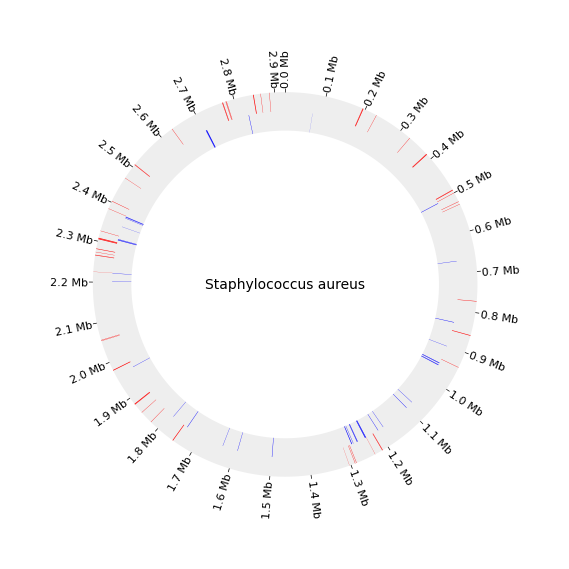

In [ ]:
# construir el mapa circular
circos = Circos(sectors={accession: genome_length}) # grafica un circulo del tamaño del genoma
circos.text("Staphylococcus aureus")
circos_gff = Gff(gff_file="candidates.gff")  # para elegir los genes a marcar en el gráfico
sector = circos.get_sector(accession)
sector = circos.sectors[0]
cds_track = sector.add_track((80, 100))
cds_track.axis(fc="#EEEEEE", ec="none")
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand =  1), r_lim=(90, 100),fc="red" ) # genes de cadena + en rojo
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand = -1), r_lim=(80,  90),fc="blue") # genes de cadena - en azul
pos_list, labels = [], []
cds_track.xticks_by_interval(
    interval=100000,     # tamaño escala
    label_formatter=lambda label_value: f"{label_value/ 1000000:.1f} Mb",  # unidades etiquetas en mega pb
    label_orientation="vertical")
fig = circos.plotfig().set_figwidth(5)  # tamaño figura 5 pulgadas

### En esta figura cada rayita corresponde a un gen, entonces las zonas donde se ven más juntas podría corresponder a un operón.

### 6.1.6 Visualización de los datos con seaborn

### Si queremos realizar una examinación más exhaustiva, podemos usar seaborn para generar una serie de gráficos llamados swarmplots en donde podemos comparar las posiciones de los genes en el dataframe completo, separando por categorias ("genes candidatos" vs "genes no candidatos") y por cadena ("+" vs "-")

### Para esto dividimos el genoma en 16 partes (esto se puede cambiar), iteramos a traves de cada una de ellas y obtenemos del df los datos de proteínas codificadas en esa región para quedarnos con las que estan en el df de candidates y en que cadena están.

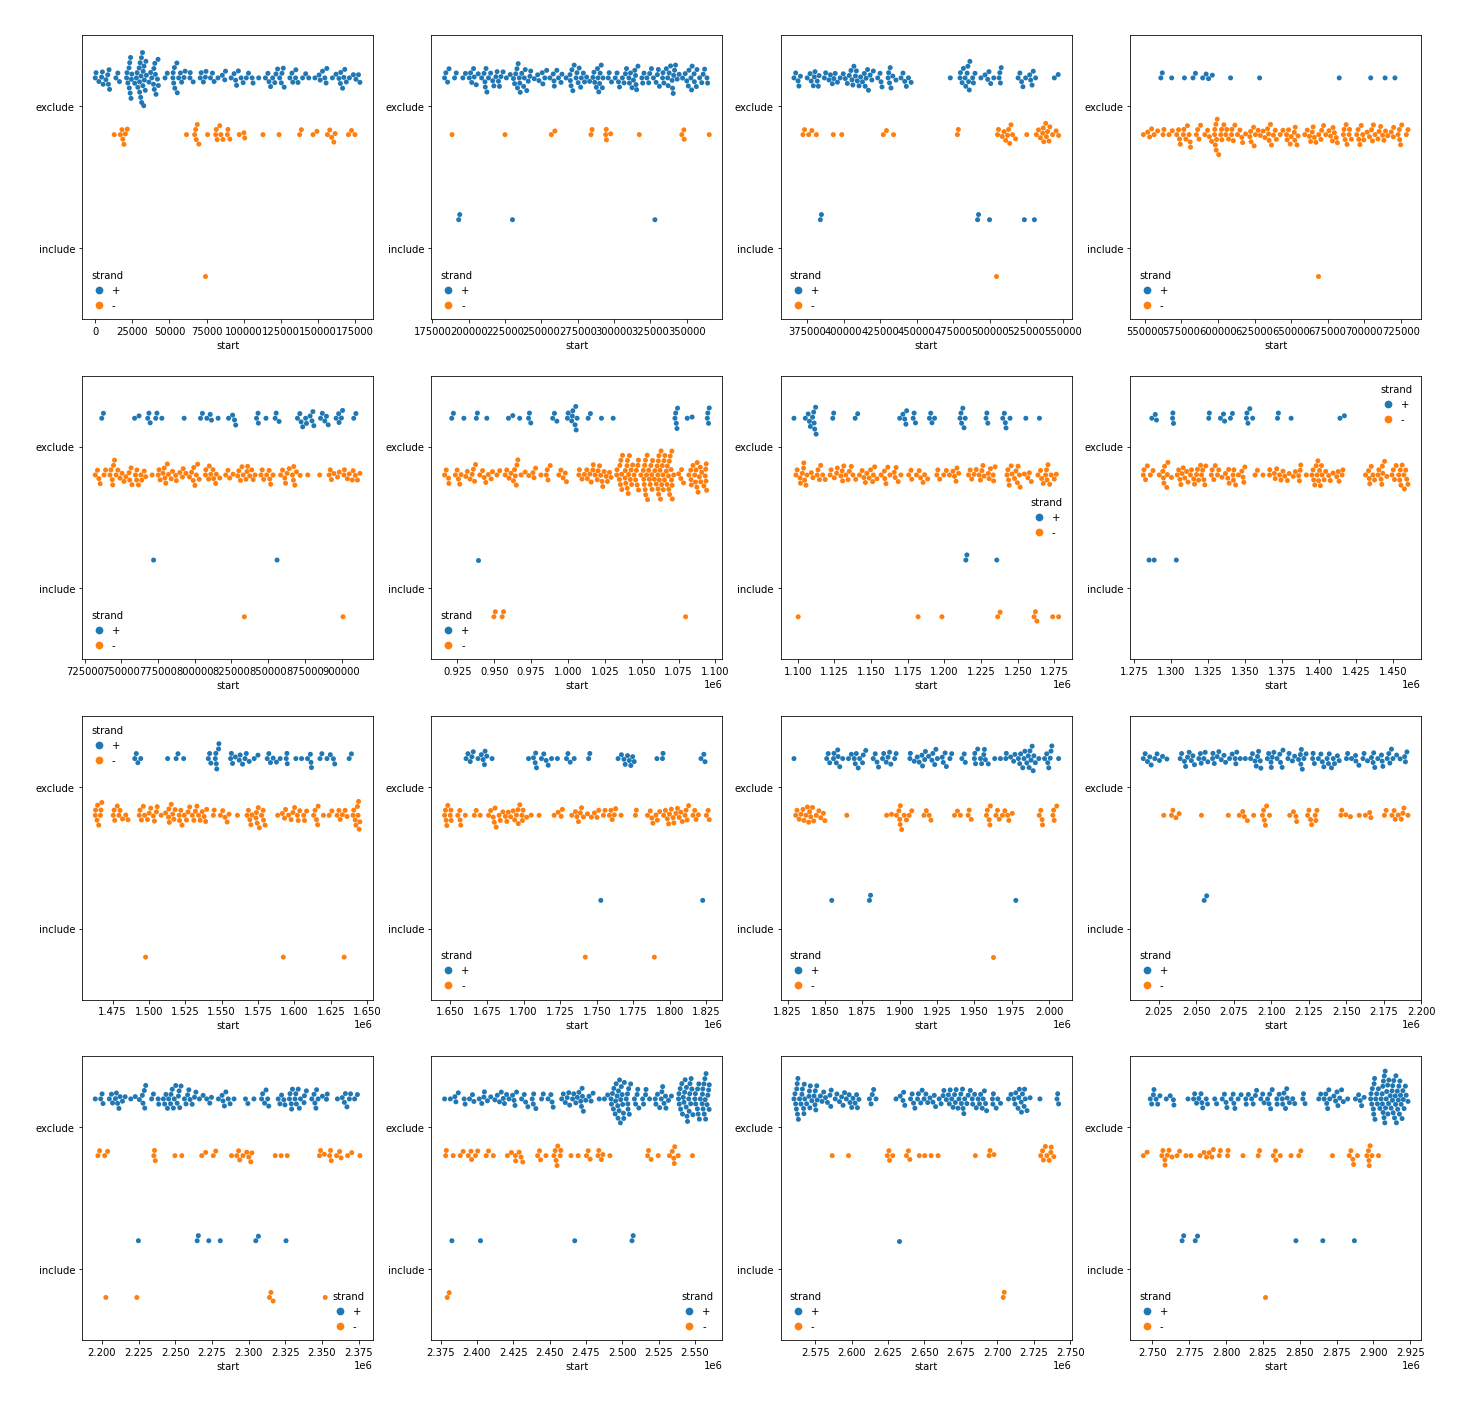

In [ ]:
# generar los swarmplots
num_bins = 16  # partimos el genoma en 16 partes
counter_1 = 0
counter_2 = 0
fig, axes = plt.subplots(4,4,figsize=(24,24))
bin_len  = (genome_length - (genome_length % (num_bins - 1))) / (num_bins)
for bin_num in range(num_bins):
    start_pos = bin_num * bin_len
    end_pos   = (bin_num + 1) * bin_len
    mb_df = gff_df.copy()
    mb_df = mb_df[(mb_df["start"]>start_pos) & (mb_df["end"]<=end_pos)]
    sns.swarmplot(ax = axes[counter_1,counter_2],data = mb_df,y="candidate",x="start",hue="strand",dodge=True,order=["exclude","include"],hue_order=["+","-"])
    axes[counter_1,counter_2].set(ylabel=None)
    counter_2 += 1
    if (counter_2%4 == 0):
        counter_2 = 0
        counter_1 += 1
plt.show()

### Cada uno de los gráficos tiene 2 partes:

### - en exclude están las proteínas que no tienen que ver con la síntesis de alfa-hemolisina
### - en include las que si, y es dónde tenemos que prestar atención

### y está marcada en azul la cadena + y en naranja la - 

### La idea ahora es seleccionar que zonas chequear con **InterProScan**, entonces voy a chequear:
### - en principio la zona ubicada entre 2300 y 2325 en la cadena negativa (que es la misma que se veia con pyCirclize y es la que se ve "más despejada" en la zona de include). 
### Si no encuentro nada podría chequear esta misma zona en la cadena + así como también la zona cerca de 0.950 en la cadena negativa.

### ... aunque en ninguno de los casos la zona de exclude se ve muy despejada...

# **7. Examinación a detalle del operón seleccionado**

### Para obtener aún más información acerca del operón que seleccionamos, podemos analizar las secuencias aminoacídicas de los genes de dicha región a través del servicio de búsqueda de dominios conservados de **InterProScan**

### Lo primero que debemos hacer es obtener los IDs de los genes presentes en dicho operón

### Para eso construimos un nuevo df a partir del df que contiene las coordenadas, pero los filtramos por posición (entre el nucleótido 2300 y 2325), etiquetados como include y pertenecientes a la cadena negativa.

In [ ]:
# obtener los IDs de los genes del operón elegido
operon_df = gff_df.copy()
operon_df = operon_df[(operon_df["start"]     >= 2300000) &
                      (operon_df["end"]       <= 2325000) &
                      (operon_df["strand"]    == "-")     &
                      (operon_df["candidate"] == "include")]
operon_df.reset_index(drop=True, inplace=True)

In [ ]:
operon_df

,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,SaurLiss,pyrodigal_v2.1.0,CDS,2314250,2315227,156.7,-,0,ID=SaurLiss_2150;partial=00;start_type=ATG;rbs...,"{'ID': 'SaurLiss_2150', 'partial': '00', 'star...",include
1,SaurLiss,pyrodigal_v2.1.0,CDS,2315229,2316176,108.5,-,0,ID=SaurLiss_2151;partial=00;start_type=ATG;rbs...,"{'ID': 'SaurLiss_2151', 'partial': '00', 'star...",include
2,SaurLiss,pyrodigal_v2.1.0,CDS,2316744,2317709,141.4,-,0,ID=SaurLiss_2152;partial=00;start_type=ATG;rbs...,"{'ID': 'SaurLiss_2152', 'partial': '00', 'star...",include


### - En principio parecen pocos (esperaba 5 genes) pero al menos mirando los ID están consecutivos.

### Del df obtenemos la lista de IDs  de los genes

In [ ]:
# obtenemos la lista de IDs
operon_gene_list = []
for index in operon_df.index.tolist():  # itera por el df
    gene_id = operon_df["annotation"][index]["ID"]   # obtiene el ID
    operon_gene_list.append(gene_id)

In [ ]:
operon_gene_list

['SaurLiss_2150', 'SaurLiss_2151', 'SaurLiss_2152']

### Para poder identificar estas proteínas tenemos que interactuar con InterProScan, entonces:

### Construímos una variable *string* para contener las secuencias aminoacídicas de los genes de interés en formato fasta

### Enviamos el *string* al servicio web de InterProScan para buscar dominios conservados en nuestras proteínas. Para esto usamos la  biblioteca **SeqIO**

> ### Antes de correr el servicio web, tenemos que eliminar los asteriscos de nuestras secuencias

In [ ]:
# definimos la variable para contener las sec de aa
query_str = ""

In [ ]:
# construímos el str de la query
for record in SeqIO.parse(aa_file, "fasta"):   # a partir del archivo con las sec de aa del genoma
    seq_id  = record.id      # recorrer los ID
    if(seq_id in operon_gene_list):  # si el ID está en la lista de IDs del operon
        seq_str = str(record.seq)     # agregarlo a query_str eliminando los *
        query_str+=">"+seq_id+"\n"+seq_str+"\n"
query_str = query_str.replace("*","")

In [ ]:
query_str

'>SaurLiss_2150\nMKMNKLVKSSVATSMALLLLSGTANAEGKITPVSVKKVDDKVTLYKTTATADSDKFKISQILTFNFIKDKSYDKDTLVLKATGNINSGFVKPNPNDYDFSKLYWGAKYNVSISSQSNDSVNVVDYAPKNQNEEFQVQNTLGYTFGGDISISNGLSGGLNGNTAFSETINYKQESYRTTLSRNTNYKNVGWGVEAHKIMNNGWGPYGRDSFHPTYGNELFLAGRQSSAYAGQNFIAQHQMPLLSRSNFNPEFLSVLSHRQDGAKKSKITVTYQREMDLYQIRWNGFYWAGANYKNFKTRTFKSTYEIDWENHKVKLLDTKETENNK\n>SaurLiss_2151\nMLKNKILATTLSVSLLAPLANPLLENAKAANDTEDIGKGSDIEIIKRTEDKTSNKWGVTQNIQFDFVKDKKYNKDALILKMQGFISSRTTYYNYKNTNHIKSMRWPFQYNIGLKTNDKYVSLINYLPKNKIESTNVSQTLGYNIGGNFQSAPSLGGNGSFNYSKSISYTQQNYVSEVEQQNSKSVLWGVKANSFATESGQKSAFDSDLFVGYKPHSKDPRDYFVPDSDLPPLVQSGFNPSFIATVSHEKGSSDTSEFEITYGRNMDVTHAIKRSTHYGNSYLDGHRIHNAFVNRNYTVKYEVNWKTHEIKVKGQN\n>SaurLiss_2152\nMNLKLNRKKVISMIKNKILTATLAVGLIAPLANPFIEISKAENKIEDIGQGAEIIKRTQDITSKRLAITQNIQFDFVKDKKYNKDALVVKMQGFISSRTTYSDLKKYPYIKRMIWPFQYNISLKTKDSNVDLINYLPKNKIDSADVSQKLGYNIGGNFQSAPSIGGSGSFNYSKTISYNQKNYVTEVESQNSKGVKWGVKANSFVTPNGQVSAYDQYLFAQDPTGPAARDYFVPDNQLPPLIQSGFNPSFITTLSHERGKGDKSEFEITYGRNMDATYAYVTRHRLAVDRKHDAFKNRNVTVKYEVN

### Estas secuencias las podemos subir a la página de InterProScan o podemos buscar los dominios funcionales mediante código (sin entrar en la página)

### Para eso el proceso de búsqueda de dominios lo dividiremos en tres etapas:

- #### Envío de las secuencias al servicio web usando la API de InterProScan
- #### Consulta del status del envío
- #### Descarga de resultados

### Cada etapa tiene una URL específica la cual definiremos a continuación

In [ ]:
submit_url   = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/run"
progress_url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/status"
results_url  = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result"

### De igual manera, cada etapa acepta headers específicos

In [ ]:
submit_headers   = {"Accept":"text/plain"}
progress_headers = {"Accept":"text/plain"}
results_headers  = {"Accept":"text/tab-separated-values"}

## 7.1 Envío de las secuencias

### En esta etapa, construiremos un diccionario de python que adjuntaremos a `requests` para buscar los dominios funcionales

In [ ]:
# armamos diccionario para hacer la consulta en la API
submit_data = {"email":"elizabethcattaneo@gmail.com",
               "title":"operon_2300_2325",
               "goterms":"false",
               "pathways":"false",
               "stype":"p",
               "sequence":query_str}

### Y ya con los datos listos enviamos nuestra solicitud a InterProScan usando la biblioteca request

In [ ]:
submit_request = requests.post(submit_url,data=submit_data,headers=submit_headers)

### La API de InterProScan entrega un código de estado y un `job_id`.

> ### El código de salida del servidor web, nos indican si la solicitud fue exitosa:
>> * 1xx informational response – the request was received, continuing process
>>* 2xx successful – the request was successfully received, understood, and accepted
>> * 3xx redirection – further action needs to be taken in order to complete the request
>> * 4xx client error – the request contains bad syntax or cannot be fulfilled
>> * 5xx server error – the server failed to fulfil an apparently valid request

### Si el servidor nos entrega un código de estado de
### - 100 a 199 las secuencias solo entraron al servidor
### - 200 a 299, nuestras secuencias entraron en el servicio web exitosamente.

### Con el siguiente código podemos obtener tanto nuestro `job_id` como el código de estado

In [ ]:
# para consultar el estado del servidor
submit_status_code = submit_request.status_code
submit_job_id      = submit_request.text

In [ ]:
print(submit_status_code)
print(submit_job_id)

200
iprscan5-R20230316-131854-0077-67549835-p1m


## 7.2 Progreso del análisis de las secuencias

### Con nuestro `job_id` podemos consultar el progreso del análisis con las siguientes líneas de código

In [ ]:
progress_request = requests.get(progress_url+"/"+submit_job_id,headers=progress_headers)
progress_status_code = progress_request.status_code
progress_status      = progress_request.text
print(progress_status_code)
print(progress_status)

200
FINISHED


### Nuevamente, si el servidor nos entrega un código de estado 200, nuestra consulta fue exitosa y tenemos que esperar a que el estado del análisis figure como "FINISHED" para poder consultar el resultado de nuestro análisis.

## 7.3 Obtención de los resultados

### Para obtener los resultados vamos a usar:

- ### `log` para acceder al reporte de texto del programa
- ### `tsv` para acceder al reporte tabular programa

In [ ]:
# se usa la biblioteca request
results_log_request = requests.get(results_url+"/"+submit_job_id+"/log",headers=results_headers)
results_tsv_request = requests.get(results_url+"/"+submit_job_id+"/tsv",headers=results_headers)

In [ ]:
# reporte del programa
# incluye las db usadas
print(results_log_request.text)

16/03/2023 13:14:30:662 Welcome to InterProScan-5.61-93.0
16/03/2023 13:14:30:663 Running InterProScan v5 in STANDALONE mode... on Linux
16/03/2023 13:14:38:839 RunID: hh-wp-02-14.ebi.ac.uk_20230316_131438524_5p00
16/03/2023 13:14:53:411 Loading file /nfs/public/rw/es/projects/wp-jdispatcher/logs/prod/sources/jobs/iprscan5/rest/20230316/1318/iprscan5-R20230316-131854-0077-67549835-p1m.sequence
16/03/2023 13:14:53:414 Running the following analyses:
[AntiFam-7.0,CDD-3.20,Coils-2.2.1,FunFam-4.3.0,Gene3D-4.3.0,Hamap-2021_04,MobiDBLite-2.0,PANTHER-17.0,Pfam-35.0,Phobius-1.01,PIRSF-3.10,PIRSR-2021_05,PRINTS-42.0,ProSitePatterns-2022_05,ProSiteProfiles-2022_05,SFLD-4,SignalP_EUK-4.1,SignalP_GRAM_NEGATIVE-4.1,SignalP_GRAM_POSITIVE-4.1,SMART-9.0,SUPERFAMILY-1.75,TIGRFAM-15.0,TMHMM-2.0c]
Available matches will be retrieved from the pre-calculated match lookup service.

Matches for any sequences that are not represented in the lookup service will be calculated locally.
16/03/2023 13:14:55:577 27

## 7.4 Examinación de los datos de dominios conservados

### results_tsv_request contiene los resultados en forma de texto sin formato, entonces usamos la biblioteca **StringIO** para incorporar nuestros resultados de `requests` en un nuevo dataframe

In [ ]:
# armar df de resultados
results_tsv_str = StringIO(results_tsv_request.text)
results_column_names = ["sequence","md5","length","database","accession","description","start","end","evalue","post_processed","date","entry","name"]
results_df = pd.read_csv(results_tsv_str,sep="\t",names=results_column_names)

In [ ]:
results_df

,sequence,md5,length,database,accession,description,start,end,evalue,post_processed,date,entry,name
0,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,Phobius,NON_CYTOPLASMIC_DOMAIN,Region of a membrane-bound protein predicted t...,35,321,-,T,16-03-2023,-,-
1,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,SignalP_GRAM_POSITIVE,SignalP-TM,SignalP-TM,1,41,-,T,16-03-2023,-,-
2,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,TIGRFAM,TIGR01002,hlyII: beta-channel forming cytolysin,18,315,3.0E-87,T,16-03-2023,IPR003963,"Bi-component toxin, staphylococci"
3,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,PRINTS,PR01468,Staphylococcal bi-component toxin signature,74,93,2.3E-30,T,16-03-2023,IPR003963,"Bi-component toxin, staphylococci"
4,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,PRINTS,PR01468,Staphylococcal bi-component toxin signature,135,156,2.3E-30,T,16-03-2023,IPR003963,"Bi-component toxin, staphylococci"
5,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,PRINTS,PR01468,Staphylococcal bi-component toxin signature,244,261,2.3E-30,T,16-03-2023,IPR003963,"Bi-component toxin, staphylococci"
6,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,Phobius,SIGNAL_PEPTIDE_H_REGION,Hydrophobic region of a signal peptide.,18,29,-,T,16-03-2023,-,-
7,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,SUPERFAMILY,SSF56959,Leukocidin-like,45,316,4.58E-109,T,16-03-2023,IPR036435,Leukocidin/porin MspA superfamily
8,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,Pfam,PF07968,Leukocidin/Hemolysin toxin family,70,310,5.9E-89,T,16-03-2023,IPR016183,Leukocidin/Hemolysin toxin
9,SaurLiss_2152,8e3f5eedfae702d7d52e1cba2f1a40fb,321,Phobius,SIGNAL_PEPTIDE_N_REGION,N-terminal region of a signal peptide.,1,17,-,T,16-03-2023,-,-


### En la columna description figuran los dominios conservados asociados a alguna función molecular encontrados en InterProSan.


### **Conclusiones acerca de la búsqueda de genes:**

### En la columna description podemos ver:

- ### algunos dominios asociados a citolisinas, pero de tipo beta.
- ### que hay varios dominios relacionados con secuencias señal (para la toxina?, proteínas que ayudan a su exportación?)
- ### no reconozco solo con la info de esa columna nada asociado a la aciltransferasa o a la ACP.

###**Conclusiones acerca de la interacción con páginas web desde Colab:**

- ### Para interactuar con NCBI, Uniprot e InterProScan no hay que hacer adaptaciones.
- ### Para usar las aplicaciones de Blast si hay que hacer adaptaciones.